In [1]:
import sys

sys.path.append("..")

In [2]:
import matplotlib.pyplot as plt

from lib import data, models

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
sample_data = data.generate_ar5_data(
    100,
    [0.5, 0.2, -0.1, 0.05, 0.02],
    10,
)

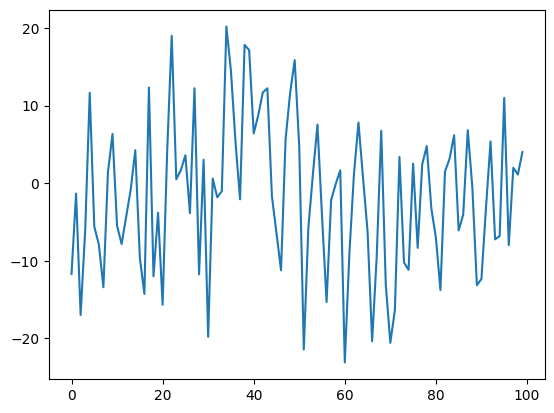

In [4]:
# Plot the data with time
time = [i for i in range(len(sample_data))]
plt.plot(time, sample_data)

In [5]:
n_chains = 10
priors = {"coefs": {"distribution": "uniform", "lower": -1, "upper": 1}, "sigma": 0.1}
n_steps = -1
data_len = len(sample_data)

In [6]:
sample_model = models.create_ar_model(
    n_chains,
    priors,
    n_steps,
    data_len,
)

/home/hope/workspace/time-series-information-criterion/.venv/lib/python3.12/site-packages/pymc/data.py:303: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
/home/hope/workspace/time-series-information-criterion/.venv/lib/python3.12/site-packages/pymc/distributions/timeseries.py:619: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100, shape=...)`. You can specify an init_dist manually to suppress this warning.
  warnings.warn(


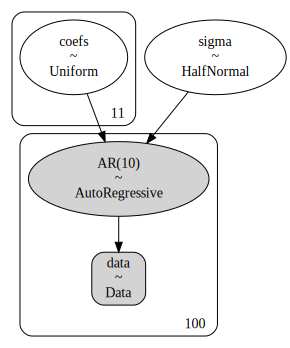

In [7]:
import pymc as pm

pm.model_to_graphviz(sample_model)

In [8]:
print(sample_model.named_vars.keys())

dict_keys(['coefs', 'sigma', 'data', 'AR(10)'])


In [9]:
with sample_model:
    # データをモデルに追加
    pm.set_data({"data": sample_data})

    # MCMCサンプリングの実行
    trace = pm.sample(draws=2000, tune=1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [coefs, sigma]


/home/hope/workspace/time-series-information-criterion/.venv/lib/python3.12/site-packages/rich/live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


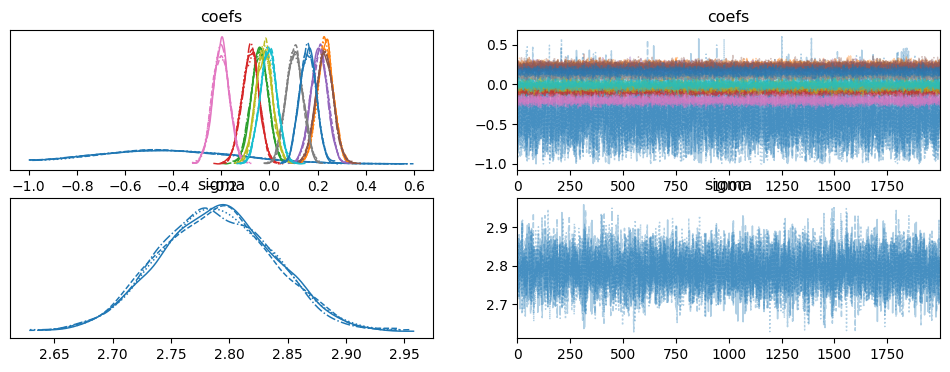

In [10]:
import arviz as az

az.plot_trace(trace)
plt.show()

In [11]:
# 事後分布の要約
summary = az.summary(trace)
print(summary)

            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
coefs[0]  -0.424  0.281  -0.954    0.070      0.003    0.003    9207.0   
coefs[1]   0.232  0.033   0.171    0.295      0.000    0.000   12027.0   
coefs[2]  -0.041  0.035  -0.106    0.025      0.000    0.000   11316.0   
coefs[3]  -0.079  0.035  -0.144   -0.012      0.000    0.000   10742.0   
coefs[4]   0.206  0.035   0.142    0.273      0.000    0.000   10943.0   
coefs[5]   0.228  0.036   0.159    0.295      0.000    0.000   11830.0   
coefs[6]  -0.202  0.035  -0.267   -0.137      0.000    0.000   11883.0   
coefs[7]   0.104  0.035   0.040    0.170      0.000    0.000   11618.0   
coefs[8]  -0.022  0.034  -0.088    0.042      0.000    0.000   10918.0   
coefs[9]  -0.004  0.035  -0.069    0.061      0.000    0.000   11144.0   
coefs[10]  0.160  0.034   0.098    0.223      0.000    0.000   12016.0   
sigma      2.789  0.049   2.696    2.878      0.000    0.000   14860.0   

           ess_tail  r_hat  
coefs[0]

In [12]:
# 事後予測サンプルの生成
with sample_model:
    posterior_predictive = pm.sample_posterior_predictive(trace)

# InferenceDataオブジェクトの作成
idata = az.convert_to_inference_data(trace)

Sampling: [AR(10)]


/home/hope/workspace/time-series-information-criterion/.venv/lib/python3.12/site-packages/rich/live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

In [13]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

In [14]:
posterior_predictive

Inference data with groups:
	> posterior_predictive
	> observed_data
	> constant_data

In [15]:
print(idata.posterior.data_vars.keys())
print(idata.observed_data.data_vars.keys())
print(posterior_predictive.posterior_predictive.data_vars.keys())

KeysView(Data variables:
    coefs    (chain, draw, coefs_dim_0) float64 704kB -0.3642 0.2388 ... 0.1049
    sigma    (chain, draw) float64 64kB 2.739 2.843 2.743 ... 2.746 2.8 2.711)
KeysView(Data variables:
    AR(10)   (AR(10)_dim_0) float64 800B -11.7 -1.35 -16.99 ... 1.115 4.009)
KeysView(Data variables:
    AR(10)   (chain, draw, AR(10)_dim_2) float64 6MB 141.9 3.813 ... -6.053)


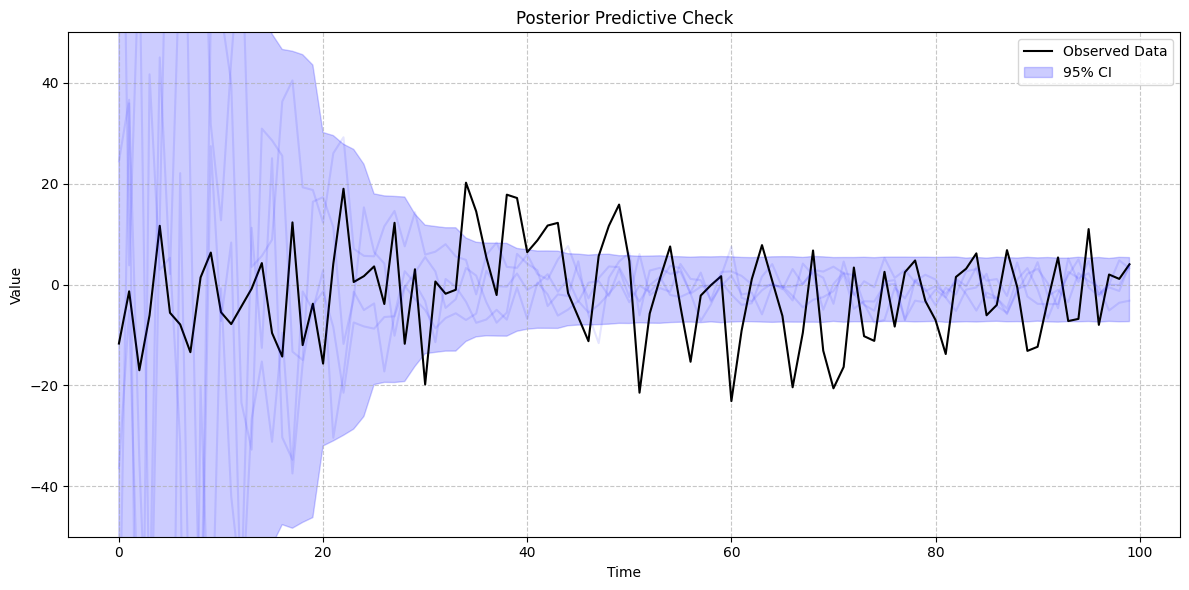

In [16]:
import numpy as np

# 予測分布のプロット
fig, ax = plt.subplots(figsize=(12, 6))

# 実際のデータをプロット
observed_data = posterior_predictive.observed_data['AR(10)'].values
time = np.arange(len(observed_data))
ax.plot(time, observed_data, color='black', label='Observed Data')

# 予測分布をプロット
y_pred = posterior_predictive.posterior_predictive['AR(10)'].values
num_samples = min(100, y_pred.shape[0])  # 最大100サンプルをプロット

for i in range(num_samples):
    ax.plot(time, y_pred[i, 0, :], color='blue', alpha=0.1)

# 95% 信頼区間をプロット
y_mean = np.mean(y_pred, axis=(0, 1))
y_std = np.std(y_pred, axis=(0, 1))
ax.fill_between(time, y_mean - 1.96 * y_std, y_mean + 1.96 * y_std, color='blue', alpha=0.2, label='95% CI')

# y軸の範囲を±50に設定
plt.ylim(-50, 50)

# プロットの設定
ax.set_title('Posterior Predictive Check')
ax.set_xlabel('Time')
ax.set_ylabel('Value')
ax.legend()

# グリッドの追加
ax.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
coefs[0]  -0.424  0.281  -0.954    0.070      0.003    0.003    9207.0   
coefs[1]   0.232  0.033   0.171    0.295      0.000    0.000   12027.0   
coefs[2]  -0.041  0.035  -0.106    0.025      0.000    0.000   11316.0   
coefs[3]  -0.079  0.035  -0.144   -0.012      0.000    0.000   10742.0   
coefs[4]   0.206  0.035   0.142    0.273      0.000    0.000   10943.0   
coefs[5]   0.228  0.036   0.159    0.295      0.000    0.000   11830.0   
coefs[6]  -0.202  0.035  -0.267   -0.137      0.000    0.000   11883.0   
coefs[7]   0.104  0.035   0.040    0.170      0.000    0.000   11618.0   
coefs[8]  -0.022  0.034  -0.088    0.042      0.000    0.000   10918.0   
coefs[9]  -0.004  0.035  -0.069    0.061      0.000    0.000   11144.0   
coefs[10]  0.160  0.034   0.098    0.223      0.000    0.000   12016.0   
sigma      2.789  0.049   2.696    2.878      0.000    0.000   14860.0   

           ess_tail  r_hat  
coefs[0]

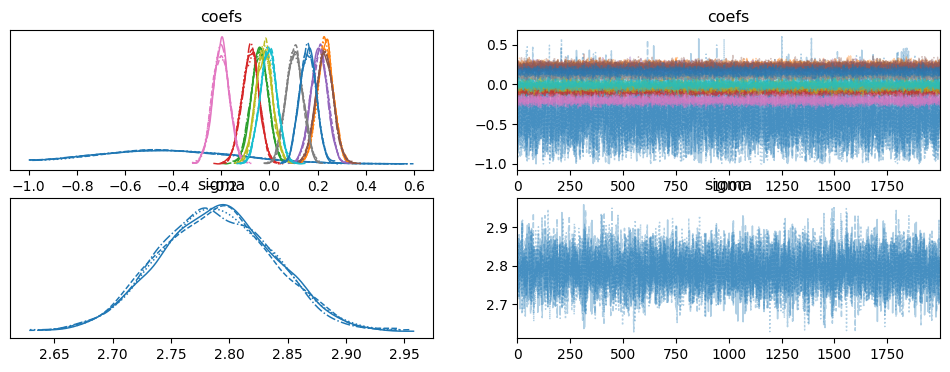

/home/hope/workspace/time-series-information-criterion/.venv/lib/python3.12/site-packages/arviz/plots/plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (48) in plot_autocorr, generating only 40 plots
  warnings.warn(


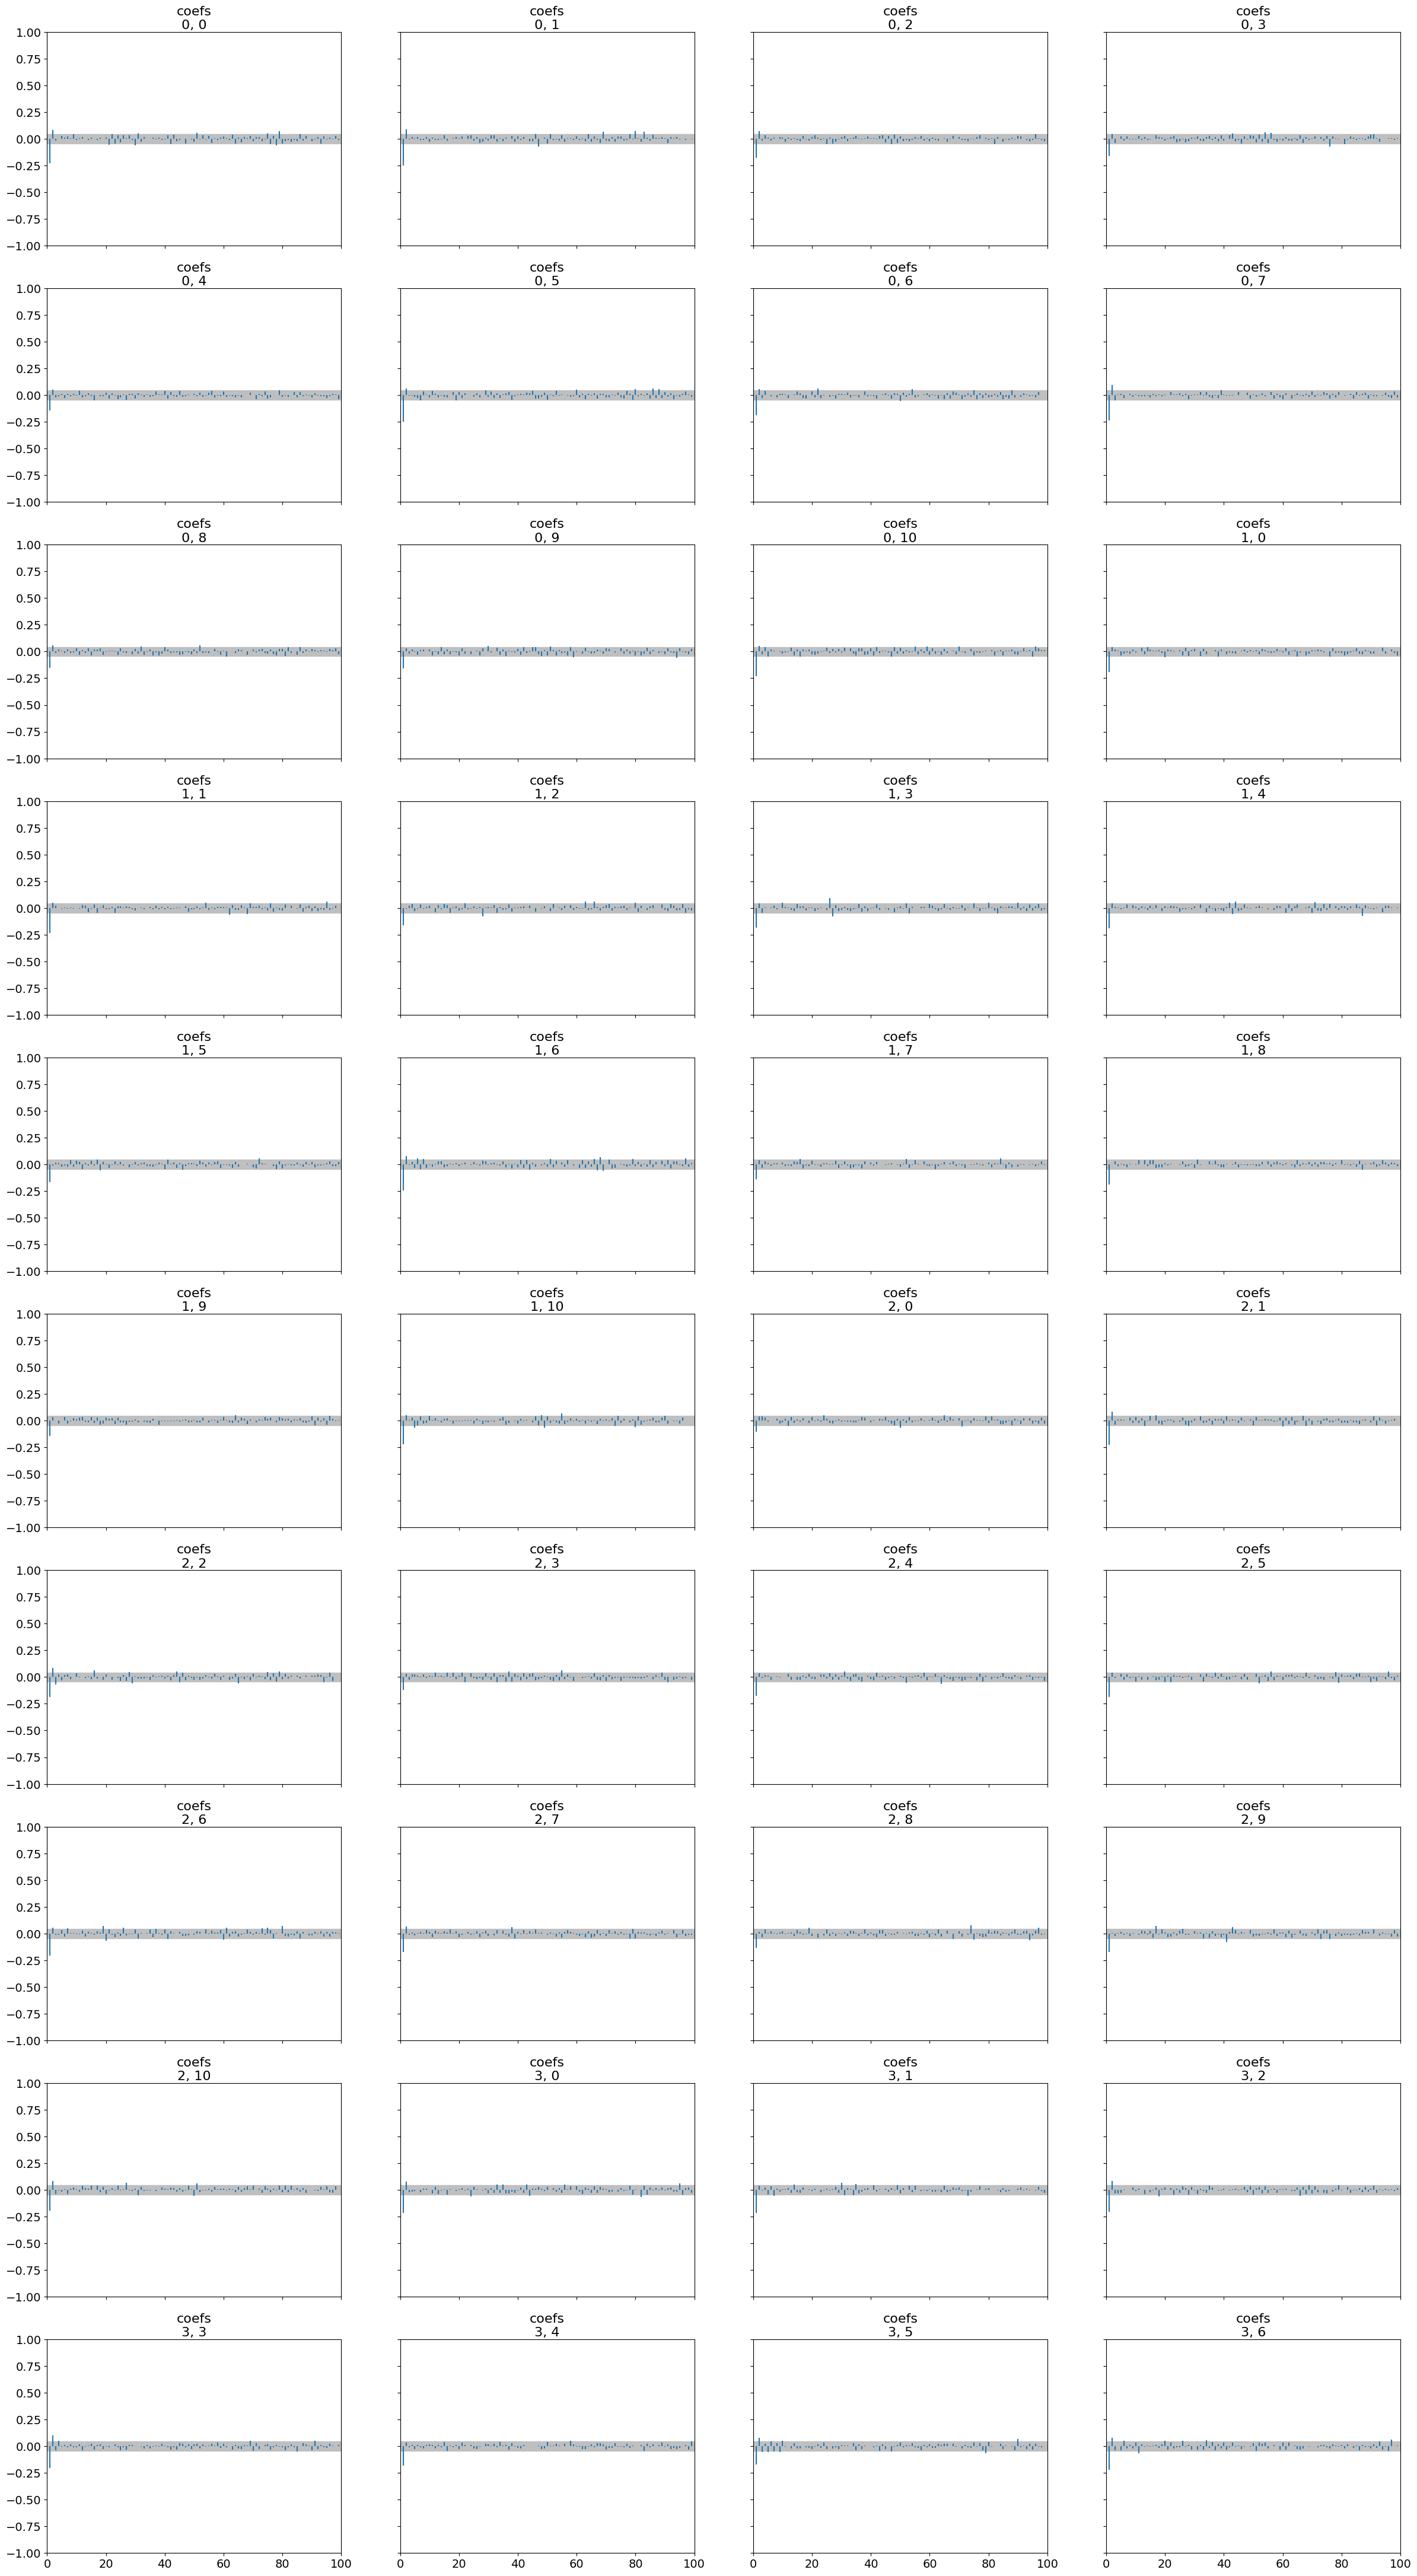

In [17]:

# 予測分布の要約統計量
summary = az.summary(idata, var_names=['coefs', 'sigma'])
print(summary)

# トレースプロット
az.plot_trace(idata, var_names=['coefs', 'sigma'])
plt.show()

# 自己相関プロット
az.plot_autocorr(idata, var_names=['coefs', 'sigma'])
plt.show()